# Analisis Predictivo de Series Temporales

-----------


## Modelos en espacio de estados: modelos de Markov escondidos (HMM)

In [78]:
install.packages("astsa")
library("astsa")

options(repr.plot.width=10, repr.plot.height=6) #ajusta tamaño de graficas


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## Modelos en espacio de estados:

La idea de los modelos en espacio de estados es poder representar procesos que tienen una *dinámica interna*, es decir:

 * Poseen un *estado* $x_t$, que evolucione en el tiempo, y que en general no es observable.
 * Podemos medir uno o más valores $y_t$, denominados *observaciones*, y cuyo comportamiento depende del estado $x_t$ en que se encuentra el proceso.
 
### Problemas:

 * Dadas las observaciones $y_0,\ldots,y_n$, ¿como reconstruimos $x_0,\ldots,x_n$?
 * Dado un conjunto de observaciones $y_0,\ldots,y_n$, ¿cómo ajustamos un modelo a la evolución del estado $x$?
 * ¿Como podemos predecir estados/observaciones futuras?

### Diagrama:

![espacio_estados](hmm.png "Estados y obsevaciones")


### Ejemplos de modelos:

 * Modelos con estados continuos y observaciones continuas (sistemas dinámicos de tiempo discreto con ruido)
     
     * Para ello se estudian herramientas matriciales, en particular el filtro de Kalman.
     * Se aplican en general cuando hay un modelo físico subyacente.
     
     
 * Modelos con estados discretos y observaciones discretas o continuas.
     
     * En este caso una buena técnica es usar **Modelos de Markov Escondidos**.
     * Los estados representan situaciones en las que se encuentra el sistema que generan respuestas distintas de acuerdo a ellos (ej: lluvioso/seco, símbolo transmitido 0 o 1, etc.)

## Modelo de Markov Escondido

Es un modelo en espacio de estados que sigue el diagrama anterior donde:

![espacio_estados](hmm.png "Estados y obsevaciones")

* El estado $X$ es discreto, pertenece a un conjunto $E=\{i,j,\ldots\}$ y es gobernado por una *cadena de Markov de tiempo discreto*.

* Las observaciones $Y_t$ son independientes en cada tiempo $t$, y su distribución depende del valor de $X_t$.


### Cadenas de Markov de tiempo discreto

Una cadena de Markov de tiempo discreto es un proceso estocástico $X_t$ que toma valores en un conjunto discreto de *estados* $E=\{i,j,\ldots\}$ y tal que:

$$P(X_{t+1} = j \mid X_t=i,X_0,\ldots,X_{t-1}) = P(X_{t+1} = j \mid X_t=i) = p_{ij}$$ 

A las $p_{ij}$ se le llaman *probabilidades de transición* y se almacenan en una *matriz de transición*:

$$P = (p_{ij}).$$

**Observación:** $p_{ij}\geqslant 0$ para todo $i,j$, y además la suma de las filas de $P$ debe dar $1$.

### Grafo de transiciones

En general a la dinámica de la cadena se la representa por un *grafo de transiciones*, un grafo dirigido donde el valor de la arista $i\to j$ es la probabilidad $p_{ij}$ (solo se ponen aristas si esta prob. no es $0$).


**Ejemplo:**

![cadena](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Markovkate_01.svg/330px-Markovkate_01.svg.png "ejemplo cadena")

En este caso $E=\{E,A\}$ y $P=\begin{pmatrix}
0.3 & 0.7\\ 0.4 & 0.6\end{pmatrix}$

In [79]:
### Ejemplo en R

# simulate discrete Markov chains according to transition matrix P
run.mc.sim <- function( P, num.iters = 50 ) {
  
  # number of possible states
  num.states <- nrow(P)
  
  # stores the states X_t through time
  states     <- numeric(num.iters)

  # initialize variable for first state 
  states[1]    <- 1

  for(t in 2:num.iters) {
    
    # probability vector to simulate next state X_{t+1}
    p  <- P[states[t-1], ]
    
    ## draw from multinomial and determine state
    states[t] <-  which(rmultinom(1, 1, p) == 1)
  }
  return(states)
}

P <- matrix(c( 0.3, 0.4 ,
                 0.7, 0.6 ), nrow=2, ncol=2)

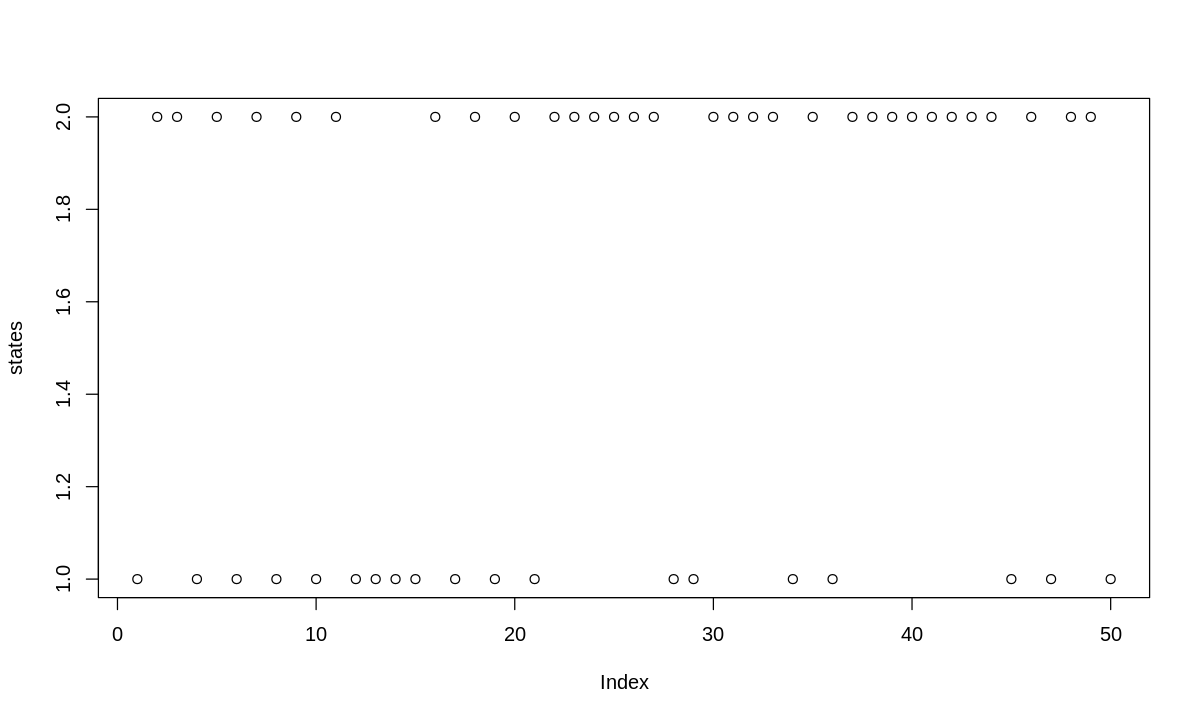

In [80]:
states <- run.mc.sim(P,50)
plot(states)

### Probabilidad de trayectoria

La probabilidad de observar una cierta secuencia de estados $x^n=(x_0,\ldots,x_n)$ está dada por:

$$p(x^n) = p(x_0)p_{x_0,x_1}p_{x_1,x_2} \cdots p_{x_{n-1},x_m} = p(x_0)\prod_{k=1}^n p_{x_{k-1},x_k}$$

Aquí $p(x_0) = P(X_0 = x_0)$ se le conoce como distribución inicial de la cadena de Markov.

Por la propiedad anterior, la probabilidad de una secuencia cualquiera $x$ está completamente determinada por:

 * La distribución incial $p(x_0) = \delta(x_0)$ (como comienza la cadena).
 * La matriz de transiciones $P$.

### Distribución de las observaciones

Resta definir como se comportan las observaciones $Y_t$ a partir de los estados. Vamos a asumir que:

 * Dado $X_t=x_t$, existe una densidad $b(y\mid x_t)$ que explica la distribución de $Y_t$. (Por ejemplo, $Y$ es gaussiana de cierta media y varianza que dependen de $x_t$).
 
 * Dada la trayectoria $x^n$, todas las observaciones son independientes entre sí (es decir, el valor de la observación no altera la dinámica).
 
Matemáticamente, se tiene que:

$$p(y^n | x^n )  = \prod_{k=0}^n b(y_k | x_k )$$

### Distribución de la observación y distribución conjunta.

De lo anterior se deduce que la distribución conjunta es:

$$p(x^n,y^n) = p(y^n\mid x^n)p(x^n) = p(x_0)b(y_0\mid x_0) \prod_{k=1}^n p_{x_{k-1},x_k}b(y_k | x_k )$$

Por último, la distribución marginal de las observaciones está dada por:

$$p(y^n) = \sum_{x^n} p(x^n,y^n).$$

Esta última es muy difícil de calcular ya que la suma es en todas las posibles trayectorias de la cadena (un número exponencialmente grande). Sin embargo, existen técnicas recursivas que simplifican su cálculo.

### Ejemplo

Consideremos una cadena $X$ como la anterior con dos estados, y con distribución inicial arrancando en el estado $1$ con probabilidad $1$ ($\delta = (1,\, 0)$).

Supongamos que $Y$ es gaussiana dada por:

$$Y_t \sim \mathcal{N}(\mu(X),\sigma^2)$$

donde $\mu(X)$ es una media que depende del estado y $\sigma^2$ es una varianza homogénea. Tomemos por ejemplo $\mu(1) = 1$, $\mu(2) = -1$ y $\sigma^2=1$. 

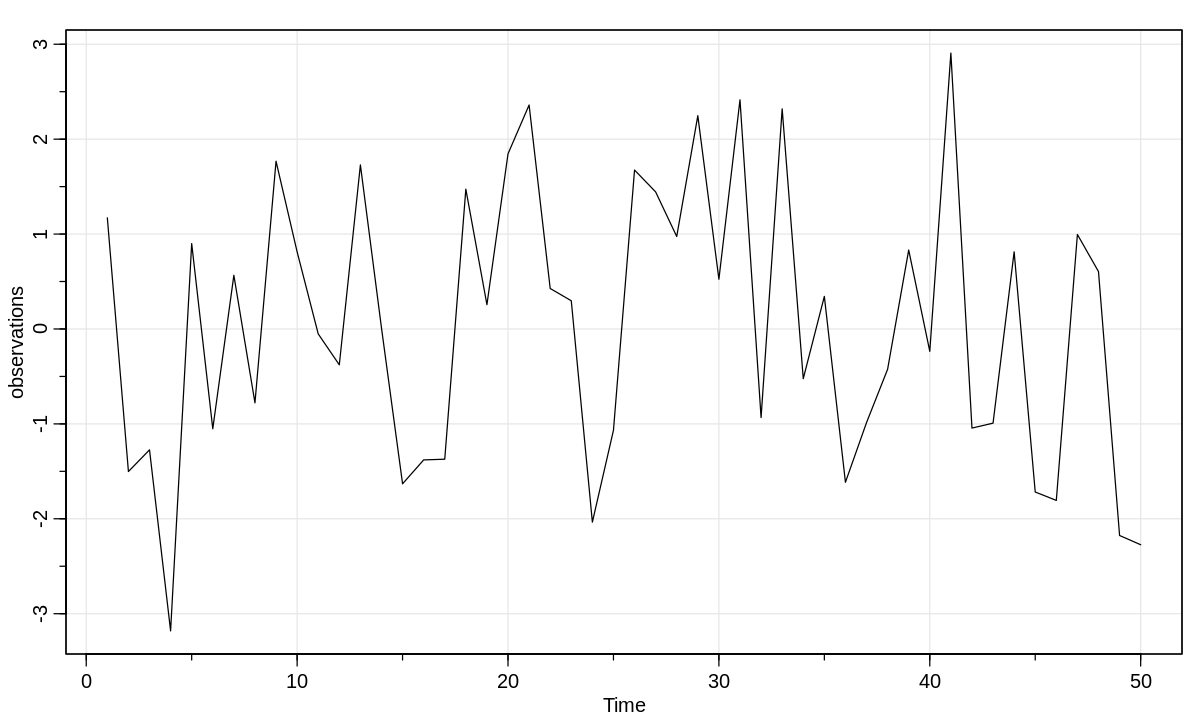

In [81]:
n=50
mu= c(1,-1)
sigma = 1

states <- run.mc.sim(P,n)
observations <- numeric(n)

for(k in 1:n) {
    observations[k] <-  rnorm(1, mean=mu[states[k]], sd=sigma)
}

tsplot(observations)

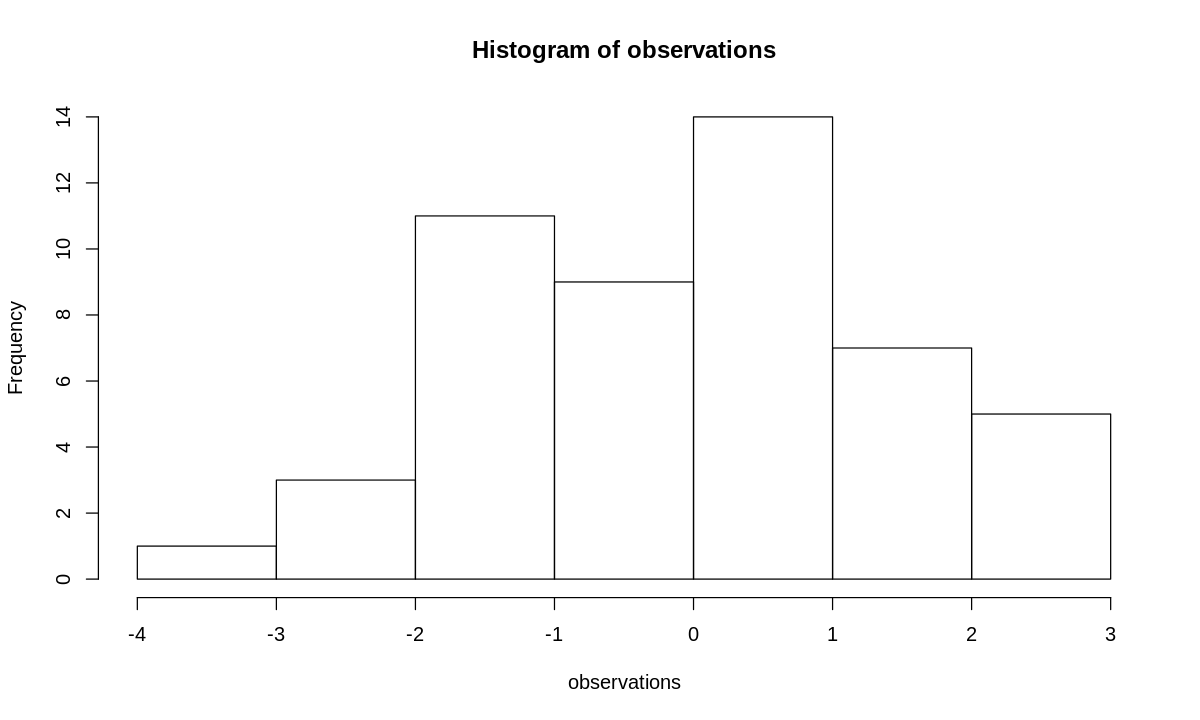

In [82]:
hist(observations)

El ejemplo anterior fue hecho "a mano", se puede hacer casi lo mismo usando la biblioteca `HiddenMarkov` de R.

In [83]:
install.packages("HiddenMarkov")
library("HiddenMarkov")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



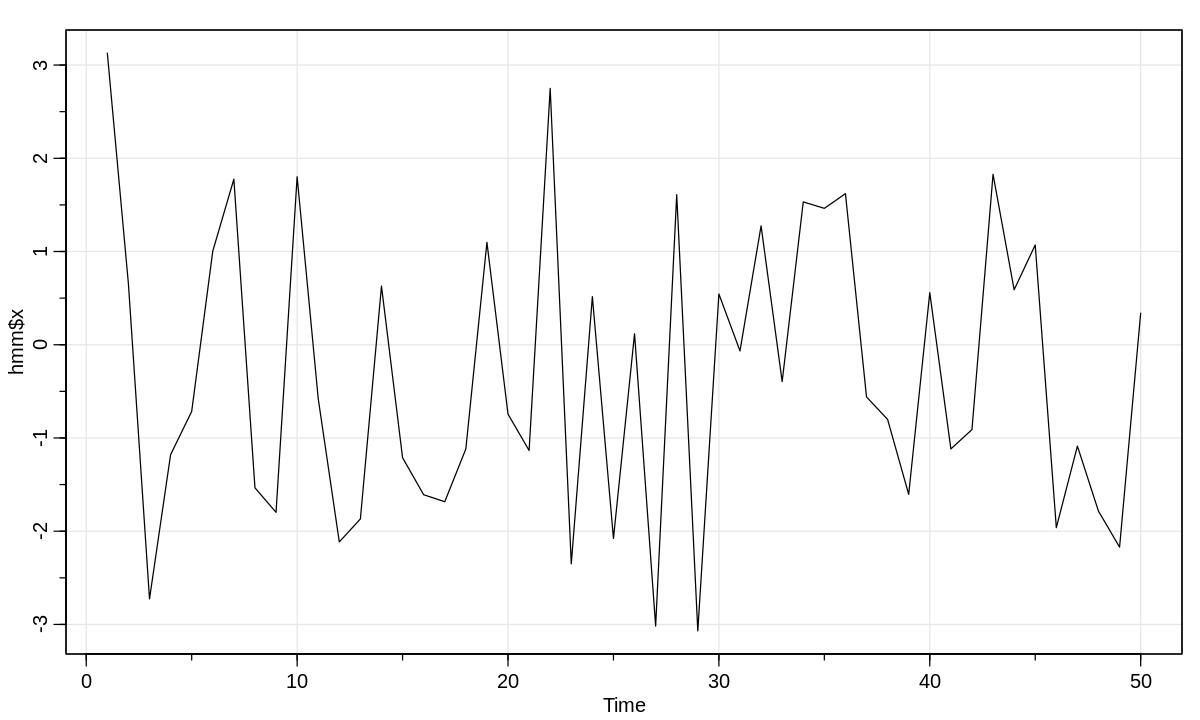

In [84]:
#construyo los paramtros
P <- matrix(c(0.3, 0.7, 0.4, 0.6),byrow=TRUE, nrow=2)
delta <- c(1, 0)

#construyo la cadena y le doy la distribucion en cada estado
hmm <- dthmm(NULL, P, delta, "norm", list(mean=c(1, -1), sd=c(1,1)))
hmm <- simulate(hmm, nsim=50)
tsplot(hmm$x)

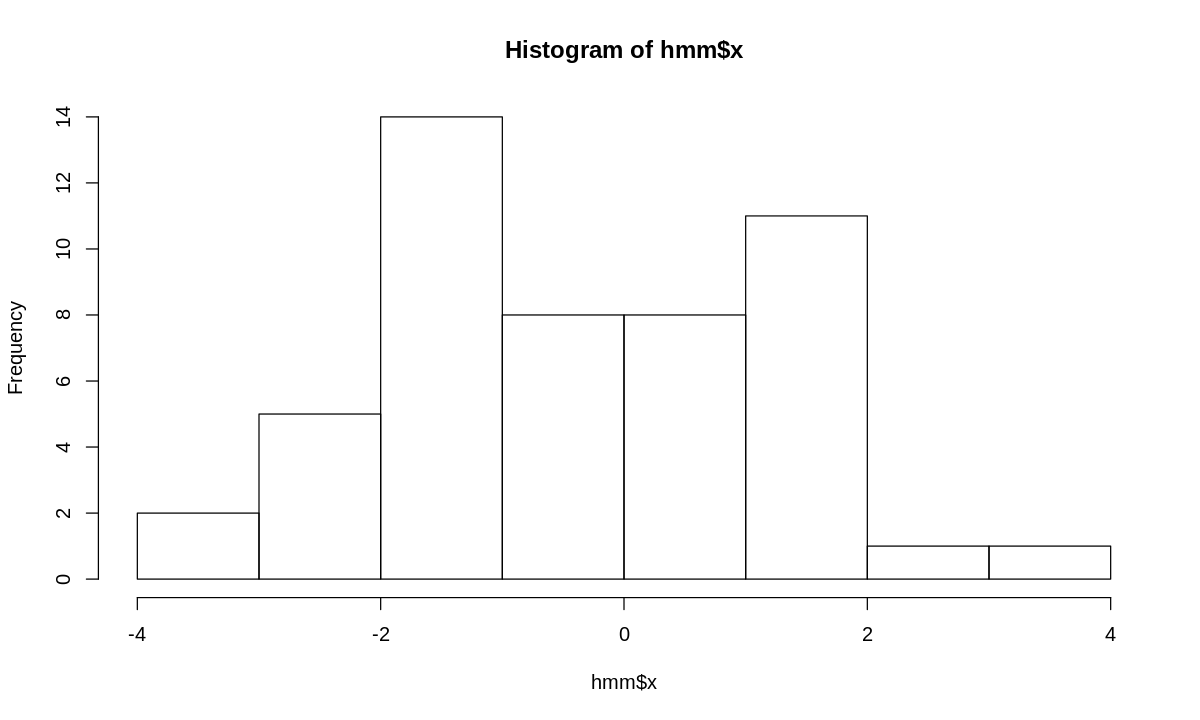

In [85]:
hist(hmm$x)

## Reconstrucción del estado

El primer problema que se presenta es: dadas las observaciones $y^n$, ¿es posible reconstruir los estados $x^n$ que las generan?

Si tengo $y^n = (y_0,\ldots,y_n)$ se separa en tres problemas:

 * Filtrado (filtering): hallar $x_n$, el estado "actual".
 * Suavizado (smoothing): hallar $x_k$ para $k<n$, es decir, reconstruir la cadena.
 * Predicción (prediction): hallar la distribución de probabilidad de $x_{n+1}$, $x_{n+2}$, etc. 

### Probabilidad condicional de estado.

La idea de estas ecuaciones es permitir calcular:

$$ p(x_k \mid y^n) = p(x_k \mid y_0,\ldots,y_n)$$

es decir, la probabilidad condicional de encontrar la cadena en $x_k$ en tiempo $k$ dada toda la lista de observaciones.

Luego podemos "reconstruir" eligiendo el *máximo a posteriori*:

$$x_k = \arg\max\{p(j \mid y^n), \quad j\in E\},$$

es decir, el estado que maximiza las chances de haber sido el correcto.

### Calculo de la probabilidad condicional: ecuaciones forward-backward

Haciendo un uso agresivo de la regla de Bayes se llega a la siguiente recurrencia para calcular las probabilidades condicionales.

#### Ec. forward, permiten calcular las probabilidades de filtrado ($k=n$)

$$p(x_0\mid y_0) = \frac{b(y_0\mid x_0)\delta(x_0)}{\sum_{x'_0}b(y_0\mid x'_0)\delta(x'_0)}$$

$$p(x_{k+1}\mid y^k) = \sum_{x_k} p(x_k\mid y_k) p_{x_{k-1},x_k}$$

$$p(x_{k+1}\mid y^{k+1}) = \frac{b(y_{k+1}\mid x_{k+1})p(x_{k+1}\mid y_k)}{\sum_{x'_{k+1}} b(y_{k+1}\mid x'_{k+1})p(x'_{k+1}\mid y_k}$$

#### Ec. backward, permiten calcular las probabilidades de suavizado ($k<n$)

$$p(x_k,x_{k+1}\mid y^n) = p(x_k \mid y^k) \frac{p_{x_k,x_{k+1}} p(x_{k+1}\mid y^n )}{p(x_{k+1}\mid y_k)}$$ 

$$p(x_k \mid y^n) = \sum_{x_{k+1}} p(x_k,x_{k+1}\mid y^n).$$

In [86]:
### Ejemplo

#aplico forward-backward: devuelve el log de las probabilidades.
fb<- forwardback(hmm$x, P, delta, "norm", list(mean=c(1, -1), sd=c(1,1)))

#calculo la verosimilitud logaritmica de cada estado
ll = fb$logalpha+fb$logbeta

xhat = numeric(n)

for (k in 1:n) {
    
    if (ll[k,1]<ll[k,2]) {
        
        xhat[k] = 1
    } else {
        xhat[k] = 2
    }
    
}

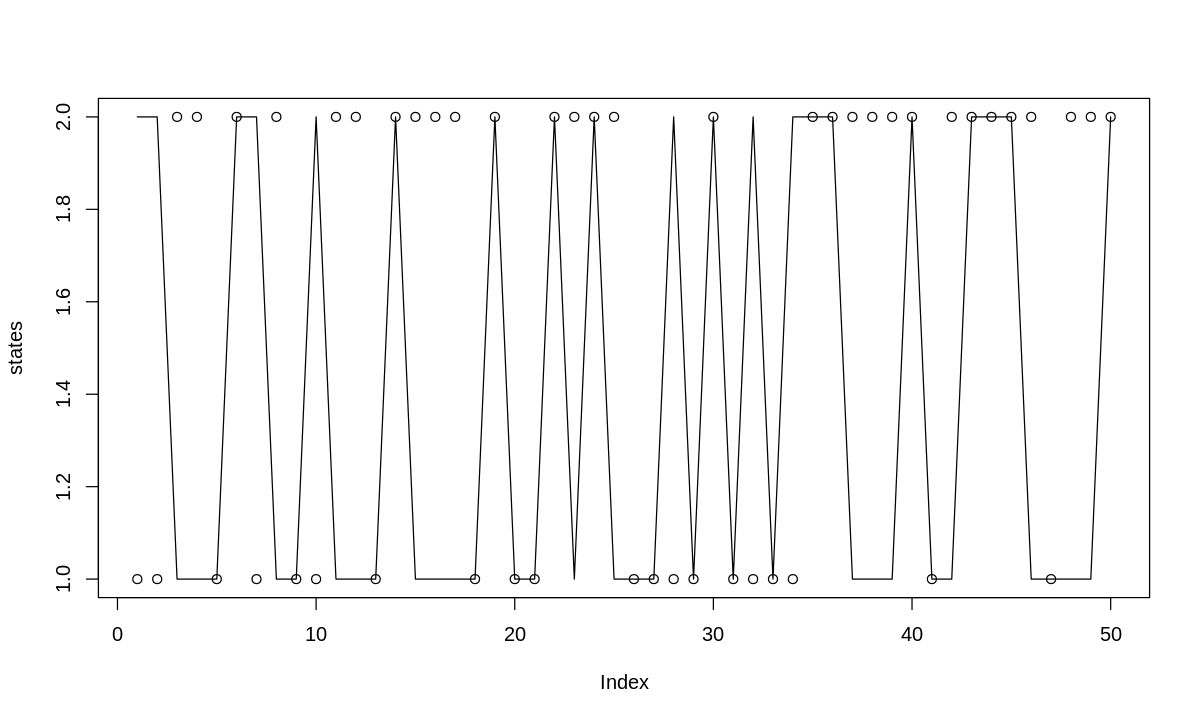

In [87]:
plot(states)
lines(xhat)
    

### Algoritmo de Viterbi para reconstrucción.

El algoritmo de Viterbi es una manera inteligente de obtener toda la secuencia $x^n$ a partir de las observaciones $y^n$ de forma que:

$$\hat{x}^n  = \arg\max\{ p(x^n\mid y^n): x^n\in E^n\}$$

es decir, la trayectoria que maximiza la verosimilitud a posteriori *entre todas las trayectorias posibles* (cant. exponencial de trayectorias).

**Observación:**

Como $p(x^n\mid y^n) = p(x^n, y^n)p(y^n)$ e $y^n$ está fijo (observación), maximizar la probabilidad a posteriori es equivalente a maximizar la probabilidad conjunta $p(x^n,y^n)$.

#### Idea 

El punto clave del algoritmo es recordar que:

$$p(x^n,y^n) = p(x_0)b(y_0\mid x_0) \prod_{k=1}^n p_{x_{k-1},x_k}b(y_k | x_k )$$

Tomando logaritmo obtenemos la log-verosimilitud conjunta en forma de suma:

$$\ell(x^n,y^n) = -\log(p(x^n,y^n)) = -\log(\delta(x_0 )b(y_0\mid x_0 ))  - \sum_{k=1}^n \log(p_{x_{k−1},x_k} b(y_k \mid x_k ))$$

Definiendo:

$$u_0(x 0 ) = − \log (\delta(x_0 )b(y_0 \mid x_0 )),$$

$$u(x_{k−1} , x_k ) = − \log(p_{x_{k−1},x_k} b(y_k \mid x_k ).$$

El costo total es:

$$U(x^n,y^n) = u_0(x_0) + \sum_{k=1}^n u(x_{k-1},x_k)$$

El problema se transforma en un problema de programación dinámica de hallar el camino más corto.

#### Algoritmo

* La trayectoria óptima para llegar al estado $x$ en tiempo $k+1$ debe pasar por algún estado en
tiempo $k$, y obviamente debe haber llegado allı́ de manera óptima (si no habrı́a una trayectoria
con menor costo). 

* Con esta idea, el costo $c_{k+1} (x)$ puede calcularse recursivamente para cada estado de la siguiente forma:

$$c_{k+1} (x) = \min_{x_k} \{c_k (x_k ) + u(x_k, x)\}.$$

* El valor de x_k donde se produce el mı́nimo es el estado anterior en la trayectoria óptima que
lleva a x y lo denotaremos $\gamma_k (x)$.

* Al llegar a $k = n$, se tienen almacenados $N$ costos $c_n (x) = U (x_{n−1} , x; y^n )$ correspondientes a cada posible estado final. La trayectoria óptima se determina entonces eligiendo de estos N costos totales el más pequeño haciendo $\hat{x}_n = \arg\min  c_n (x)$ y luego recursivamente hacia atrás, $\hat{x}_k = \gamma_k(x_{k+1})$.

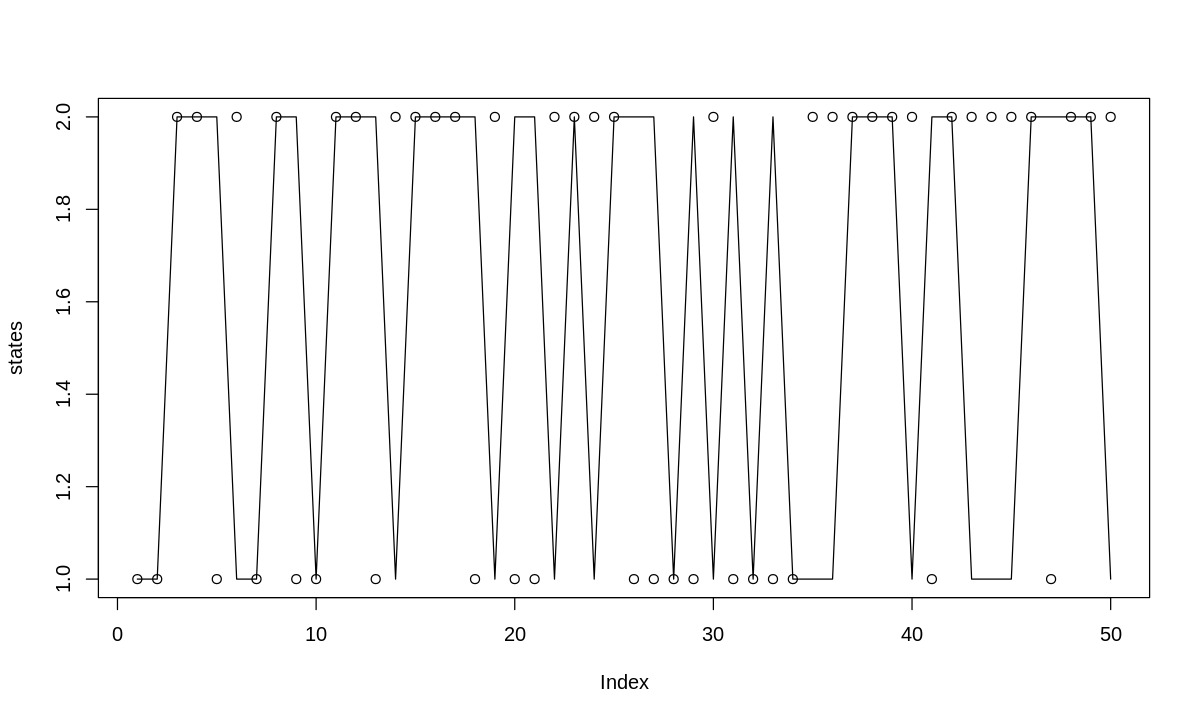

In [94]:
### Ejemplo

xhat <- Viterbi(hmm)

plot(states)
lines(xhat)

### Ajuste de modelos HMM

Lo veremos en otro cuaderno con Camila

## Ejercicio

Se desea realizar un modelo para la llegada de pacientes diarios a la emergencia de un hospital. Podemos suponer que:

 * El estado oculto de "demanda" es bajo, medio o alto. Solo puede cambiar de bajo a medio o de medio a alto, y en promedio se queda una semana en cada estado.
 
 * Para cada estado, la cantidad de pacientes que llegan a la emergencia es una v.a. Poisson con media $\lambda_{bajo} =500$, $\lambda_{medio} = 75$ y $\lambda_{alto}=100$.
 
Simular usando la biblioteca `HiddenMarkov` una trayectoria de este proceso y plotear. Observar el comportamiento. Aplicar las técnicas vistas para recuperar el estado de demanda a partir de los conteos.